In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transunet_till_epoch_150/pytorch/default/1/checkpoint_1.pth
/kaggle/input/transunet_till_epoch_100/pytorch/default/1/checkpoint_1.pth
/kaggle/input/transunet_till_epoch_50/pytorch/default/1/checkpoint_1.pth
/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/Filtered_Masks/20191026T195815_539_mask.png
/kaggle/input/unetdata/TN_images/TN_images/TN_images/01580PSFHSAoP4k_1580.png
/kaggle/input/unetdata/test_Masks/test_Masks/test_Masks/00844_PSFHAoP4k_mask.png
/kaggle/input/unetdata/denoised_Standard_plane/denoised_Standard_plane/Standard_plane/20191115T105730_719.png


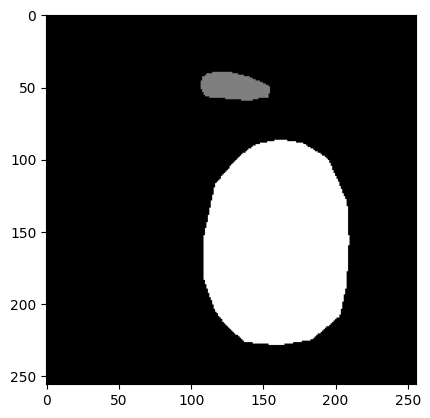

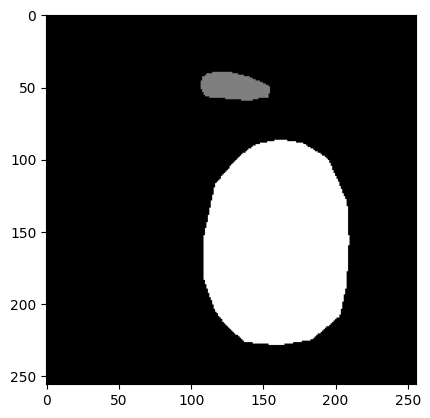

In [2]:
import cv2
import matplotlib.pyplot as plt
mask1 = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)

mask = cv2.imread("/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/Filtered_Masks/00006_PSFHAoP4k_mask.png",0)  
mask_contour= cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)       #  detects boundaries
mask_img = cv2.drawContours(mask,mask_contour[0],0,255, -1)      # draws boundary on an image


img = cv2.cvtColor(mask1, cv2.COLOR_BGR2RGB)
# Show the image
plt.imshow(img)
plt.show()

img1 = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()

In [3]:
def pad_image_to_square(img):
    if img.dim() == 3:  # For tensors with channels: [C, H, W]
        channels, height, width = img.shape
    elif img.dim() == 2:  # For tensors without channels: [H, W]
        height, width = img.shape
        channels = None
    else:
        raise ValueError("Input tensor must be 2D or 3D")

    # Calculate padding
    if height > width:
        pad_size = (height - width) // 2
        padding = (pad_size, height - width - pad_size, 0, 0)  # Left, right, top, bottom
    elif width > height:
        pad_size = (width - height) // 2
        padding = (0, 0, pad_size, width - height - pad_size)  # Left, right, top, bottom
    else:
        return img  # Already square, no padding needed

    # Apply padding
    padded_img = torch.nn.functional.pad(img.unsqueeze(0), padding, mode="constant", value=0).squeeze(0)
    if channels:
        return padded_img
    else:
        return padded_img.squeeze(0)  # Remove channel dimension if it was 2D

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import os
import pandas as pd
from torchvision.io import read_image
import torch.utils.data as data

class CustomDataset(Dataset):
    def __init__(self, img_path, target_path, transform, target_transform):
        self.img_path = img_path 
        self.target_path = target_path
        self.transform = transform
        self.target_transform = target_transform

        # Define the mapping of pixel values to class labels
        self.class_mapping = {0: 0, 76: 1, 127: 1, 149: 2, 255: 2}  # Adjust based on your dataset

    def __len__(self):
        return len(os.listdir(self.img_path))

    def __getitem__(self, index):
        # Load and process the image
        img_path = os.path.join(self.img_path, sorted(os.listdir(self.img_path))[index])
        img = read_image(img_path)
        img_name = os.path.basename(img_path)
        img = pad_image_to_square(img)
        img = img.float() / 255.0
        

        # Load and process the target mask
        if self.target_path:
            mask_path = os.path.join(self.target_path, sorted(os.listdir(self.target_path))[index])
            mask_name = os.path.basename(mask_path)
            target = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            target = torch.from_numpy(target).long()  # Convert to long tensor
            target = pad_image_to_square(target)

            # Apply mapping to convert pixel values to class labels
            for key, value in self.class_mapping.items():
                target[target == key] = value

            # print(f"Remapped unique values in mask: {torch.unique(target)}")  # Debugging remapped values

            if self.target_transform and len(target.size()) > 1:
                target = self.target_transform(target.unsqueeze(0)).squeeze(0)
        else:
            target = torch.tensor([])

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)

        return img.float(), target,  img_name, mask_name

# Define the transformation to resize the images to a fixed size
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Use nearest interpolation to preserve class labels in the target masks
transform1 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.NEAREST),
])

# Instantiate dataset objects
dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/denoised_Standard_plane/denoised_Standard_plane/Standard_plane',
    target_path='/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/Filtered_Masks',
    transform=transform,
    target_transform=transform1
)

test_dataset = CustomDataset(
    img_path='/kaggle/input/unetdata/TN_images/TN_images/TN_images',
    target_path='/kaggle/input/unetdata/test_Masks/test_Masks/test_Masks',
    transform=transform,
    target_transform=transform1
)

# Check the number of images
img_path = '/kaggle/input/unetdata/denoised_Standard_plane/denoised_Standard_plane/Standard_plane'
print(len(os.listdir(img_path)))

target_path = '/kaggle/input/unetdata/Filtered_Masks/Filtered_Masks/Filtered_Masks'
print(len(os.listdir(target_path)))

test_img_path = '/kaggle/input/unetdata/TN_images/TN_images/TN_images'
print(len(os.listdir(test_img_path)))

test_target_path = '/kaggle/input/unetdata/test_Masks/test_Masks/test_Masks'
print(len(os.listdir(test_target_path)))

# Split the dataset into training and validation sets
# train_dataset, val_dataset = data.random_split(dataset, [6067, 1517], generator=torch.Generator().manual_seed(42))

# Create train and validation dataloaders
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

7584
7584
1414
1414


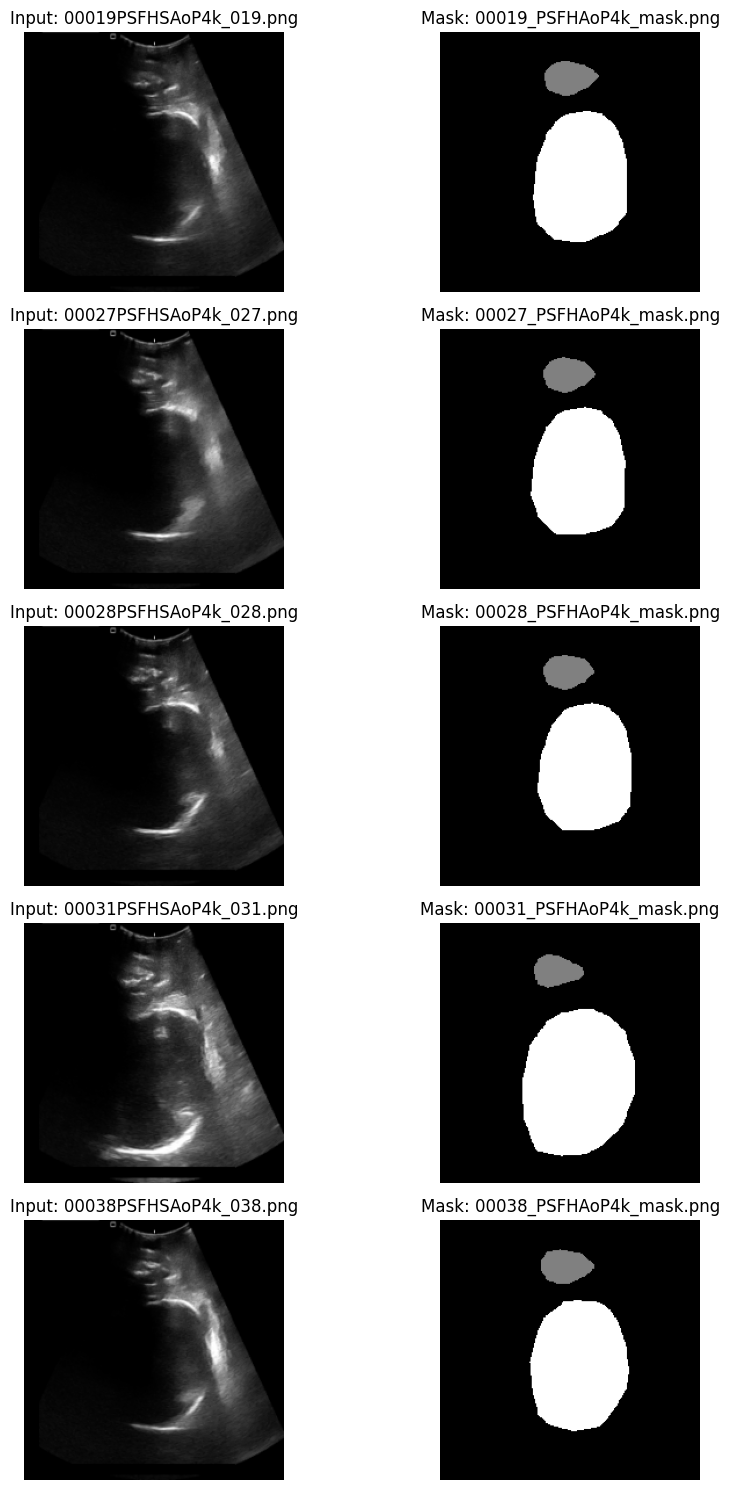

In [5]:
import matplotlib.pyplot as plt
import torch


# Get one batch of data
for i, batch in enumerate(test_dataloader):
    if i == 1:
        break  # Only take the first batch

    # Unpack batch
    images, masks, img_names, mask_names = batch  # images: (batch_size, C, H, W), masks: (batch_size, H, W)

    num_images = min(5, images.shape[0])  # Show up to 5 images

    # Create a figure with 5 rows and 2 columns
    fig, axs = plt.subplots(nrows=num_images, ncols=2, figsize=(10, num_images * 3))

    for j in range(num_images):
        # Original Image (Column 1)
        axs[j, 0].imshow(images[j, 0].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 0].set_title(f"Input: {img_names[j]}")
        axs[j, 0].axis('off')

        # Corresponding Mask (Column 2)
        axs[j, 1].imshow(masks[j].cpu().numpy(), cmap='gray')  # Convert to NumPy
        axs[j, 1].set_title(f"Mask: {mask_names[j]}")
        axs[j, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available, running on CPU.")

Using GPU: Tesla T4


In [7]:
from os.path import join as pjoin
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install ml_collections



class PreActBottleneck(nn.Module):
    """Pre-activation (v2) bottleneck block.
    """

    def __init__(self, cin, cout=None, cmid=None, stride=1):
        super().__init__()
        cout = cout or cin
        cmid = cmid or cout//4

        self.gn1 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv1 = conv1x1(cin, cmid, bias=False)
        self.gn2 = nn.GroupNorm(32, cmid, eps=1e-6)
        self.conv2 = conv3x3(cmid, cmid, stride, bias=False)  # Original code has it on conv1!!
        self.gn3 = nn.GroupNorm(32, cout, eps=1e-6)
        self.conv3 = conv1x1(cmid, cout, bias=False)
        self.relu = nn.ReLU(inplace=True)

        if (stride != 1 or cin != cout):
            # Projection also with pre-activation according to paper.
            self.downsample = conv1x1(cin, cout, stride, bias=False)
            self.gn_proj = nn.GroupNorm(cout, cout)

    def forward(self, x):

        # Residual branch
        residual = x
        if hasattr(self, 'downsample'):
            residual = self.downsample(x)
            residual = self.gn_proj(residual)

        # Unit's branch
        y = self.relu(self.gn1(self.conv1(x)))
        y = self.relu(self.gn2(self.conv2(y)))
        y = self.gn3(self.conv3(y))

        y = self.relu(residual + y)
        return y

    def load_from(self, weights, n_block, n_unit):
        conv1_weight = np2th(weights[pjoin(n_block, n_unit, "conv1/kernel").replace('\\', '/')], conv=True)
        conv2_weight = np2th(weights[pjoin(n_block, n_unit, "conv2/kernel").replace('\\', '/')], conv=True)
        conv3_weight = np2th(weights[pjoin(n_block, n_unit, "conv3/kernel").replace('\\', '/')], conv=True)

        gn1_weight = np2th(weights[pjoin(n_block, n_unit, "gn1/scale").replace('\\', '/')])
        gn1_bias = np2th(weights[pjoin(n_block, n_unit, "gn1/bias").replace('\\', '/')])

        gn2_weight = np2th(weights[pjoin(n_block, n_unit, "gn2/scale").replace('\\', '/')])
        gn2_bias = np2th(weights[pjoin(n_block, n_unit, "gn2/bias").replace('\\', '/')])

        gn3_weight = np2th(weights[pjoin(n_block, n_unit, "gn3/scale").replace('\\', '/')])
        gn3_bias = np2th(weights[pjoin(n_block, n_unit, "gn3/bias").replace('\\', '/')])

        self.conv1.weight.copy_(conv1_weight)
        self.conv2.weight.copy_(conv2_weight)
        self.conv3.weight.copy_(conv3_weight)

        self.gn1.weight.copy_(gn1_weight.view(-1))
        self.gn1.bias.copy_(gn1_bias.view(-1))

        self.gn2.weight.copy_(gn2_weight.view(-1))
        self.gn2.bias.copy_(gn2_bias.view(-1))

        self.gn3.weight.copy_(gn3_weight.view(-1))
        self.gn3.bias.copy_(gn3_bias.view(-1))

        if hasattr(self, 'downsample'):
            proj_conv_weight = np2th(weights[pjoin(n_block, n_unit, "conv_proj/kernel").replace('\\', '/')], conv=True)
            proj_gn_weight = np2th(weights[pjoin(n_block, n_unit, "gn_proj/scale").replace('\\', '/')])
            proj_gn_bias = np2th(weights[pjoin(n_block, n_unit, "gn_proj/bias").replace('\\', '/')])

            self.downsample.weight.copy_(proj_conv_weight)
            self.gn_proj.weight.copy_(proj_gn_weight.view(-1))
            self.gn_proj.bias.copy_(proj_gn_bias.view(-1))

def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)

#standardize the weights before doing convolution
#weight -->(output_channel,input_channel,kernel_size[0],kernel_size[1])
#So compute mean and variance for each input_channel*kernel_size[0]*kernel_size[1]
class StdConv2d(nn.Conv2d):

    def forward(self, x):
        w = self.weight
        v, m = torch.var_mean(w, dim=[1, 2, 3], keepdim=True, unbiased=False)
        w = (w - m) / torch.sqrt(v + 1e-5)
        return F.conv2d(x, w, self.bias, self.stride, self.padding,
                        self.dilation, self.groups)

#do convolution using StdConv2d
def conv3x3(cin, cout, stride=1, groups=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=3, stride=stride,
                     padding=1, bias=bias, groups=groups)


def conv1x1(cin, cout, stride=1, bias=False):
    return StdConv2d(cin, cout, kernel_size=1, stride=stride,
                     padding=0, bias=bias)



class ResNetV2(nn.Module):
    """Implementation of Pre-activation (v2) ResNet mode."""

    def __init__(self, block_units, width_factor):
        super().__init__()
        width = int(64 * width_factor)
        self.width = width

        self.root = nn.Sequential(OrderedDict([
            ('conv', StdConv2d(1, width, kernel_size=7, stride=2, bias=False, padding=3)),
            ('gn', nn.GroupNorm(32, width, eps=1e-6)),
            ('relu', nn.ReLU(inplace=True)),
            # ('pool', nn.MaxPool2d(kernel_size=3, stride=2, padding=0))
        ]))

        self.body = nn.Sequential(OrderedDict([
            ('block1', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width, cout=width*4, cmid=width))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*4, cout=width*4, cmid=width)) for i in range(2, block_units[0] + 1)],
                ))),
            ('block2', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*4, cout=width*8, cmid=width*2, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*8, cout=width*8, cmid=width*2)) for i in range(2, block_units[1] + 1)],
                ))),
            ('block3', nn.Sequential(OrderedDict(
                [('unit1', PreActBottleneck(cin=width*8, cout=width*16, cmid=width*4, stride=2))] +
                [(f'unit{i:d}', PreActBottleneck(cin=width*16, cout=width*16, cmid=width*4)) for i in range(2, block_units[2] + 1)],
                ))),
        ]))

    def forward(self, x):
        features = []
        b, c, in_size, _ = x.size()
        x = self.root(x)
        features.append(x)
        x = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)(x)
        for i in range(len(self.body)-1):
            #According to paper, you have to concatenate the the output of resnet
            #blocks with decoder part so you have to make sure that the height and
            #width matches
            x = self.body[i](x)
            right_size = int(in_size / 4 / (i+1))
            if x.size()[2] != right_size:
                pad = right_size - x.size()[2]
                assert pad < 3 and pad > 0, "x {} should {}".format(x.size(), right_size)
                feat = torch.zeros((b, x.size()[1], right_size, right_size), device=x.device)
                feat[:, :, 0:x.size()[2], 0:x.size()[3]] = x[:]
            else:
                feat = x
            features.append(feat)
        x = self.body[-1](x)
        return x, features[::-1]


# coding=utf-8
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import copy
import logging
import math
import ml_collections
from os.path import join as pjoin

import torch
import torch.nn as nn
import numpy as np

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair
from scipy import ndimage
logger = logging.getLogger(__name__)
def get_b16_config():
    """Returns the ViT-B/16 configuration."""
    config = ml_collections.ConfigDict()
    config.patches = ml_collections.ConfigDict({'size': (16, 16)})
    config.hidden_size = 768
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1

    config.classifier = 'seg'
    config.representation_size = None
    config.resnet_pretrained_path = None
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/ViT-B_16.npz'
    config.patch_size = 16

    config.decoder_channels = (256, 128, 64, 16)
    config.n_classes = 3
    config.activation = 'softmax'
    return config

def get_r50_b16_config():
    """Returns the Resnet50 + ViT-B/16 configuration."""
    config = get_b16_config()
    config.patches.grid = (16, 16)
    config.resnet = ml_collections.ConfigDict()
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1

    config.classifier = 'seg'
    config.pretrained_path = '../model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz'
    config.decoder_channels = (256, 128, 64, 16)
    config.skip_channels = [512, 256, 64, 16]
    config.n_classes = 3
    config.n_skip = 3
    config.activation = 'softmax'

    return config
CONFIGS = {
    'ViT-B_16': get_b16_config(),
    'R50-ViT-B_16': get_r50_b16_config(),

}


class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, config, img_size, in_channels=1):
        super(Embeddings, self).__init__()
        self.hybrid = None
        self.config = config
        img_size = _pair(img_size)
        #print(config.patches.get("grid"))
        #print(img_size)
        if config.patches.get("grid") is not None:   # ResNet
            grid_size = config.patches["grid"]
            #print(grid_size)
            patch_size = (max(1,img_size[0] // 16 // grid_size[0]), max(1,img_size[1] // 16 // grid_size[1]))
            patch_size_real = (patch_size[0] * 16, patch_size[1] * 16)
            #print(patch_size,patch_size_real)
            n_patches = (img_size[0] // patch_size_real[0]) * (img_size[1] // patch_size_real[1])

            self.hybrid = True
        else:
            patch_size = _pair(config.patches["size"])
            n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
            self.hybrid = False

        if self.hybrid:
            self.hybrid_model = ResNetV2(block_units=config.resnet.num_layers, width_factor=config.resnet.width_factor)
            in_channels = self.hybrid_model.width * 16
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=config.hidden_size,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, config.hidden_size))

        self.dropout = Dropout(config.transformer["dropout_rate"])


    def forward(self, x):
        if self.hybrid:
            x, features = self.hybrid_model(x)
        else:
            features = None
        x = self.patch_embeddings(x)  # (B, hidden. n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)

        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings, features


ATTENTION_Q = "MultiHeadDotProductAttention_1/query"
ATTENTION_K = "MultiHeadDotProductAttention_1/key"
ATTENTION_V = "MultiHeadDotProductAttention_1/value"
ATTENTION_OUT = "MultiHeadDotProductAttention_1/out"
FC_0 = "MlpBlock_3/Dense_0"
FC_1 = "MlpBlock_3/Dense_1"
ATTENTION_NORM = "LayerNorm_0"
MLP_NORM = "LayerNorm_2"


def np2th(weights, conv=False):
    """Possibly convert HWIO to OIHW."""
    if conv:
        weights = weights.transpose([3, 2, 0, 1])
    return torch.from_numpy(weights)


def swish(x):
    return x * torch.sigmoid(x)


ACT2FN = {"gelu": torch.nn.functional.gelu, "relu": torch.nn.functional.relu, "swish": swish}


class Attention(nn.Module):
    def __init__(self, config, vis):
        super(Attention, self).__init__()
        self.vis = vis
        self.num_attention_heads = config.transformer["num_heads"]
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(config.hidden_size, self.all_head_size)
        self.key = Linear(config.hidden_size, self.all_head_size)
        self.value = Linear(config.hidden_size, self.all_head_size)

        self.out = Linear(config.hidden_size, config.hidden_size)
        self.attn_dropout = Dropout(config.transformer["attention_dropout_rate"])
        self.proj_dropout = Dropout(config.transformer["attention_dropout_rate"])

        self.softmax = Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs if self.vis else None
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights

class Mlp(nn.Module):
    def __init__(self, config):
        super(Mlp, self).__init__()
        self.fc1 = Linear(config.hidden_size, config.transformer["mlp_dim"])
        self.fc2 = Linear(config.transformer["mlp_dim"], config.hidden_size)
        self.act_fn = ACT2FN["gelu"]
        self.dropout = Dropout(config.transformer["dropout_rate"])

        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, config, vis):
        super(Block, self).__init__()
        self.hidden_size = config.hidden_size
        self.attention_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn_norm = LayerNorm(config.hidden_size, eps=1e-6)
        self.ffn = Mlp(config)
        self.attn = Attention(config, vis)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
        x = x + h

        h = x
        x = self.ffn_norm(x)
        x = self.ffn(x)
        x = x + h
        return x, weights

    def load_from(self, weights, n_block):
        ROOT = f"Transformer/encoderblock_{n_block}"
        with torch.no_grad():
            Temp=weights
            query_weight = np2th(weights[pjoin(ROOT,ATTENTION_Q,"kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            key_weight = np2th(weights[pjoin(ROOT, ATTENTION_K, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            value_weight = np2th(weights[pjoin(ROOT, ATTENTION_V, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()
            out_weight = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "kernel").replace('\\', '/')]).view(self.hidden_size, self.hidden_size).t()

            query_bias = np2th(weights[pjoin(ROOT, ATTENTION_Q, "bias").replace('\\', '/')]).view(-1)
            key_bias = np2th(weights[pjoin(ROOT, ATTENTION_K, "bias").replace('\\', '/')]).view(-1)
            value_bias = np2th(weights[pjoin(ROOT, ATTENTION_V, "bias").replace('\\', '/')]).view(-1)
            out_bias = np2th(weights[pjoin(ROOT, ATTENTION_OUT, "bias").replace('\\', '/')]).view(-1)

            self.attn.query.weight.copy_(query_weight)
            self.attn.key.weight.copy_(key_weight)
            self.attn.value.weight.copy_(value_weight)
            self.attn.out.weight.copy_(out_weight)
            self.attn.query.bias.copy_(query_bias)
            self.attn.key.bias.copy_(key_bias)
            self.attn.value.bias.copy_(value_bias)
            self.attn.out.bias.copy_(out_bias)

            mlp_weight_0 = np2th(weights[pjoin(ROOT, FC_0, "kernel").replace('\\', '/')]).t()
            mlp_weight_1 = np2th(weights[pjoin(ROOT, FC_1, "kernel").replace('\\', '/')]).t()
            mlp_bias_0 = np2th(weights[pjoin(ROOT, FC_0, "bias").replace('\\', '/')]).t()
            mlp_bias_1 = np2th(weights[pjoin(ROOT, FC_1, "bias").replace('\\', '/')]).t()

            self.ffn.fc1.weight.copy_(mlp_weight_0)
            self.ffn.fc2.weight.copy_(mlp_weight_1)
            self.ffn.fc1.bias.copy_(mlp_bias_0)
            self.ffn.fc2.bias.copy_(mlp_bias_1)

            self.attention_norm.weight.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "scale").replace('\\', '/')]))
            self.attention_norm.bias.copy_(np2th(weights[pjoin(ROOT, ATTENTION_NORM, "bias").replace('\\', '/')]))
            self.ffn_norm.weight.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "scale").replace('\\', '/')]))
            self.ffn_norm.bias.copy_(np2th(weights[pjoin(ROOT, MLP_NORM, "bias").replace('\\', '/')]))

class Encoder(nn.Module):
    def __init__(self, config, vis):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(config.hidden_size, eps=1e-6)
        for _ in range(config.transformer["num_layers"]):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):


        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

class Transformer(nn.Module):
    def __init__(self, config, img_size, vis):
        super(Transformer, self).__init__()
        self.embeddings = Embeddings(config, img_size=img_size)
        self.encoder = Encoder(config, vis)

    def forward(self, input_ids):
        embedding_output, features = self.embeddings(input_ids)
        encoded, attn_weights = self.encoder(embedding_output)  # (B, n_patch, hidden)
        return encoded, attn_weights, features

class Conv2dReLU(nn.Sequential):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):
        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        bn = nn.BatchNorm2d(out_channels)

        super(Conv2dReLU, self).__init__(conv, bn, relu)

class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            skip_channels=0,
            use_batchnorm=True,
    ):
        super().__init__()
        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.up = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x, skip=None):
        x = self.up(x)
        # print("skip: ",skip)
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        head_channels = 512
        self.conv_more = Conv2dReLU(
            config.hidden_size,
            head_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=True,
        )
        decoder_channels = config.decoder_channels
        in_channels = [head_channels] + list(decoder_channels[:-1])
        out_channels = decoder_channels

        if self.config.n_skip != 0:
            skip_channels = self.config.skip_channels
            for i in range(4-self.config.n_skip):  # re-select the skip channels according to n_skip
                skip_channels[3-i]=0

        else:
            skip_channels=[0,0,0,0]

        blocks = [
            DecoderBlock(in_ch, out_ch, sk_ch) for in_ch, out_ch, sk_ch in zip(in_channels, out_channels, skip_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, hidden_states, features=None):
        B, n_patch, hidden = hidden_states.size()  # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = hidden_states.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = self.conv_more(x)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.config.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x


class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        super().__init__(conv2d, upsampling)


class VisionTransformer(nn.Module):
    def __init__(self, config, img_size=224, num_classes=3, zero_head=False, vis=False):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.zero_head = zero_head
        self.classifier = config.classifier
        self.transformer = Transformer(config, img_size, vis)
        self.decoder = DecoderCup(config)
        self.segmentation_head = SegmentationHead(
            in_channels=config['decoder_channels'][-1],
            out_channels=config['n_classes'],
            kernel_size=3,
        )
        self.config = config

    def forward(self, x):
        # if x.size()[1] == 1:
        #     x = x.repeat(1,3,1,1)
        # print(x.shape)
        x, attn_weights, features = self.transformer(x)  # (B, n_patch, hidden)
        x = self.decoder(x, features)
        logits = self.segmentation_head(x)
        return logits


    def load_from(self, weights):
        with torch.no_grad():

            res_weight = weights
            self.transformer.embeddings.patch_embeddings.weight.copy_(np2th(weights["embedding/kernel"], conv=True))
            self.transformer.embeddings.patch_embeddings.bias.copy_(np2th(weights["embedding/bias"]))

            self.transformer.encoder.encoder_norm.weight.copy_(np2th(weights["Transformer/encoder_norm/scale"]))
            self.transformer.encoder.encoder_norm.bias.copy_(np2th(weights["Transformer/encoder_norm/bias"]))

            posemb = np2th(weights["Transformer/posembed_input/pos_embedding"])

            posemb_new = self.transformer.embeddings.position_embeddings
            if posemb.size() == posemb_new.size():
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            elif posemb.size()[1]-1 == posemb_new.size()[1]:
                posemb = posemb[:, 1:]
                self.transformer.embeddings.position_embeddings.copy_(posemb)
            else:
                logger.info("load_pretrained: resized variant: %s to %s" % (posemb.size(), posemb_new.size()))
                ntok_new = posemb_new.size(1)
                if self.classifier == "seg":
                    _, posemb_grid = posemb[:, :1], posemb[0, 1:]
                gs_old = int(np.sqrt(len(posemb_grid)))
                gs_new = int(np.sqrt(ntok_new))
                print('load_pretrained: grid-size from %s to %s' % (gs_old, gs_new))
                posemb_grid = posemb_grid.reshape(gs_old, gs_old, -1)
                zoom = (gs_new / gs_old, gs_new / gs_old, 1)
                posemb_grid = ndimage.zoom(posemb_grid, zoom, order=1)  # th2np
                posemb_grid = posemb_grid.reshape(1, gs_new * gs_new, -1)
                posemb = posemb_grid
                self.transformer.embeddings.position_embeddings.copy_(np2th(posemb))

            # Encoder whole
            for bname, block in self.transformer.encoder.named_children():
                for uname, unit in block.named_children():
                    unit.load_from(weights, n_block=uname)

            if self.transformer.embeddings.hybrid:
                self.transformer.embeddings.hybrid_model.root.conv.weight.copy_(np2th(res_weight["conv_root/kernel"], conv=True))
                gn_weight = np2th(res_weight["gn_root/scale"]).view(-1)
                gn_bias = np2th(res_weight["gn_root/bias"]).view(-1)
                self.transformer.embeddings.hybrid_model.root.gn.weight.copy_(gn_weight)
                self.transformer.embeddings.hybrid_model.root.gn.bias.copy_(gn_bias)

                for bname, block in self.transformer.embeddings.hybrid_model.body.named_children():
                    for uname, unit in block.named_children():
                        unit.load_from(res_weight, n_block=bname, n_unit=uname)
                        

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.5 MB/s eta 0:00:00


In [8]:
!pip install torchinfo
from torchinfo import summary
    

config = CONFIGS['R50-ViT-B_16']
model = VisionTransformer(config)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)
# Print summary
summary(model, input_size=(1,1, 224, 224))

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (hybrid_model): ResNetV2(
        (root): Sequential(
          (conv): StdConv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (gn): GroupNorm(32, 64, eps=1e-06, affine=True)
          (relu): ReLU(inplace=True)
        )
        (body): Sequential(
          (block1): Sequential(
            (unit1): PreActBottleneck(
              (gn1): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (gn2): GroupNorm(32, 64, eps=1e-06, affine=True)
              (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (gn3): GroupNorm(32, 256, eps=1e-06, affine=True)
              (conv3): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (relu): ReLU(inplace=True)
              (downsample): StdConv2d(64, 256, 

Layer (type:depth-idx)                                  Output Shape              Param #
VisionTransformer                                       [1, 3, 224, 224]          --
├─Transformer: 1-1                                      [1, 196, 768]             --
│    └─Embeddings: 2-1                                  [1, 196, 768]             150,528
│    │    └─ResNetV2: 3-1                               [1, 1024, 14, 14]         11,888,576
│    │    └─Conv2d: 3-2                                 [1, 768, 14, 14]          787,200
│    │    └─Dropout: 3-3                                [1, 196, 768]             --
│    └─Encoder: 2-2                                     [1, 196, 768]             --
│    │    └─ModuleList: 3-4                             --                        85,054,464
│    │    └─LayerNorm: 3-5                              [1, 196, 768]             1,536
├─DecoderCup: 1-2                                       [1, 16, 224, 224]         --
│    └─Conv2dReLU: 2-3         

In [9]:
import torch
torch.cuda.empty_cache()  # Free up unused memory

In [10]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [11]:
for batch in train_dataloader:
        inputs, targets, img_names, mask_names = batch
        print(f"Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
        print(f"Target unique values: {torch.unique(targets)}")
        break

Inputs shape: torch.Size([64, 1, 224, 224]), Targets shape: torch.Size([64, 224, 224])
Target unique values: tensor([0, 1, 2])


In [12]:
import copy


class EarlyStopping:
    def __init__(self, patience, min_delta=0.01, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None  # Initialize best_model to None
        self.best_loss = float('inf')  # Initialize best_loss to a large value
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        # Check if it's the first epoch or if validation loss improved
        if val_loss < self.best_loss:  # Use '<' to check for improvement
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"Early stopping triggered after {self.counter} epochs."
                if self.restore_best_weights:
                    if self.best_model is not None:  # Check if best_model exists before loading
                        model.load_state_dict(self.best_model)
                    else:
                        print("Warning: No best model found to restore.")
                return True
        return False

In [13]:
def save_checkpoint(model, optimizer, path, epoch, early_stopping, all_train_loss, all_val_loss, all_train_dice,
                   all_val_dice,all_train_dice_wo, all_val_dice_wo, all_train_jaccard,all_val_jaccard, all_train_voe, all_val_voe, all_train_rvd,
                   all_val_rvd):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': early_stopping.best_loss,
        'counter': early_stopping.counter,
        'all_train_loss': all_train_loss,
        'all_val_loss': all_val_loss,
        'all_train_dice': all_train_dice,
        'all_val_dice': all_val_dice,
        'all_train_dice_wo': all_train_dice_wo,
        'all_val_dice_wo': all_val_dice_wo,
        'all_train_jaccard': all_train_jaccard,
        'all_val_jaccard': all_val_jaccard,
        'all_train_voe': all_train_voe,
        'all_val_voe': all_val_voe,
        'all_train_rvd': all_train_rvd,
        'all_val_rvd': all_val_rvd,
    }
    torch.save(checkpoint, path)


def save_best_model(model,path):
    checkpoint = {
        'model_state_dict': model.state_dict()
    }
    torch.save(checkpoint,path)

In [14]:
# def match_dims_with_pred_mask(groundtruth_mask):
#   # print("Shape of groundtruth_mask before one-hot encoding:", groundtruth_mask.shape)

#   num_classes = 3
#   groundtruth_mask = np.eye(num_classes)[groundtruth_mask]  
#   # print("Shape after one-hot encoding (temporary):", groundtruth_mask.shape)

#   groundtruth_mask = np.moveaxis(groundtruth_mask, -1, 1)  
#   # print("Shape after axis reordering:", groundtruth_mask.shape)
#   return groundtruth_mask


# Dice score: Measures the overlap between the predicted and ground truth masks. A value of 1 indicates perfect overlap.
# The more the better
def dice_coef_without_class(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    # print("pred_mask shape: ",pred_mask.shape)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
    
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask) + smooth
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask) + smooth
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 5)

def dice_coef(pred_masks, groundtruth_masks):
    
    pred_masks = np.array(pred_masks)
    # print("pred_masks shape: ",pred_masks.shape)
    groundtruth_masks = np.array(groundtruth_masks)
    # groundtruth_masks = match_dims_with_pred_mask(groundtruth_masks)

    smooth = 1e-6  # Smoothing value to avoid division by zero
    dice_per_class = []
    num_classes = 3

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        pred_class = (pred_masks == class_idx).astype(np.float32)
        groundtruth_class = (groundtruth_masks == class_idx).astype(np.float32)

        # Calculate Dice for the current class
        intersection = np.sum(pred_class * groundtruth_class, axis=(1, 2))  # Sum over spatial dimensions
        total_sum = np.sum(pred_class, axis=(1, 2)) + np.sum(groundtruth_class, axis=(1, 2))
        dice_class = (2. * intersection + smooth) / (total_sum + smooth)

        # Average Dice across the batch for this class
        dice_per_class.append(np.mean(dice_class))

    # Macro-average Dice (mean across all classes)
    mean_dice = np.mean(dice_per_class)
    return round(mean_dice, 5)

    # smooth = 0.001
    # dice_per_class = torch.zeros(3)
    # for class_id in range(3):
    #     y_pred_class = (pred_masks == class_id).float()
    #     y_true_class = (groundtruth_masks == class_id).float()

    #     intersection = torch.sum(y_pred_class*y_true_class)
    #     dice_per_class[class_id] = (2.0 * intersection + smooth) / (
    #         torch.sum(y_pred_class) + torch.sum(y_true_class)+smooth
    #     )

    # return dice_per_class



# Jaccard Index (IoU): Measures the intersection over the union of the predicted and ground truth masks.
# The more the better
def iou(pred_mask,groundtruth_mask):
    pred_mask = np.array(pred_mask)
    groundtruth_mask = np.array(groundtruth_mask)
    # groundtruth_mask = match_dims_with_pred_mask(groundtruth_mask)
 
    smooth = 0.0001
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = (intersect + smooth) / (union + smooth)  # Calculate per image IoU
    return round(np.mean(iou),5)  # Average IoU across all images in the batch


# Average Surface Distance (ASD): Measures the average distance between the boundary points of the predicted mask and the ground truth mask.
# The less the better


# Volume Overlap Error (VOE): For non-binary masks, VOE can be adapted by considering the sum of pixel values as a "soft overlap"
# Lower values are better.
def voe(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    intersection = np.sum(np.minimum(pred_mask, gt_mask))  # Soft overlap
    union = np.sum(np.maximum(pred_mask, gt_mask))        # Soft union
    voe = 1 - ((intersection+smooth) / (union+smooth))
    return round(voe,5)


# Relative Volume Difference (RVD): RVD is particularly useful for applications where the total volume
# (e.g., of an organ or lesion) is more important than boundary alignment. It captures whether 
# the predicted segmentation overestimates or underestimates the actual volume.
# The range of Relative Volume Difference (RVD) is unbounded and can theoretically span from −∞ to +∞, depending 
# on the degree of overestimation or underestimation of the predicted volume compared to the ground truth volume. 

# Negative RVD (RVD<0):Indicates that the predicted volume is smaller than the ground truth.
# Example: RVD=−0.2 means the predicted volume is 20% smaller.

# Zero RVD (RVD=0): Indicates a perfect match between the predicted and ground truth volumes.

# Positive RVD (RVD>0): Indicates that the predicted volume is larger than the ground truth.
# Example: RVD=0.15 means the predicted volume is 15% larger.

# Lower values are better.

def rvd(pred_mask, gt_mask):
    pred_mask = np.array(pred_mask)
    gt_mask = np.array(gt_mask)
    # gt_mask = match_dims_with_pred_mask(gt_mask)

    smooth = 0.0001
    pred_volume = np.sum(pred_mask)  # Sum of intensities
    gt_volume = np.sum(gt_mask)     # Sum of intensities
    rvd = (pred_volume - gt_volume) / (gt_volume)
    return round(rvd,5)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
# from dataset import MyDataset
# from model import UNet

# torch.cuda.empty_cache()

import gc
# del inputs , targets , model
gc.collect()



# Define hyperparameters
learning_rate = 0.001
num_epochs = 200
patience = 30
early_stopping = EarlyStopping(patience=patience)
early_stop = False

k_folds = 5
batch_size = 16


def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed globally
set_seed(42)


train_loaders = []
val_loaders = []
kf = KFold(n_splits=k_folds, shuffle=True)

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    # Define the data loaders for the current fold
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    val_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        sampler=torch.utils.data.SubsetRandomSampler(val_idx),
    )

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

    print(f"Fold {fold + 1}")
    print("-------")

    # for batch in train_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Train Batch:", img_names)  

    # # Print image names for val_loader
    # print(f"Validation images in Fold {fold + 1}:")
    # for batch in val_loader:
    #     _, _, img_names, mask_names = batch
    #     print("Validation Batch:", img_names)
        
    print(f"Train_loader: {len(train_loaders[fold])}")
    print(f"Val_loader: {len(val_loaders[fold])}")

    if (fold+1) % 5 == 0:
        break

print(len(train_loaders))
print(len(val_loaders))



# Define the U-Net architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VisionTransformer(config).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


PATH = "/kaggle/working/checkpoint_1.pth"
outputCheckpoint_path = "/kaggle/outputs/checkpoint_1.pth"

load_PATH = "/kaggle/input/transunet_till_epoch_150/pytorch/default/1/checkpoint_1.pth"

bestModel_path = "/kaggle/working/best_model.pth"
output_bestModel_path = "/kaggle/outputs/best_model.pth"


os.makedirs("/kaggle/working", exist_ok=True)
os.makedirs("/kaggle/outputs", exist_ok=True)

# import os
# print(f"File exists: {os.path.exists(load_PATH)}")
# print(f"File size: {os.path.getsize(load_PATH)} bytes")



if (os.path.exists(PATH) and os.path.getsize(PATH) > 0) or (os.path.exists(load_PATH) and os.path.getsize(load_PATH)>0):
    if os.path.exists(load_PATH):
        load_PATH = load_PATH
        print("input LOAD_PATH")
    else:
        load_PATH = PATH
        print("output path")
        
    # checkpoint = torch.load(load_PATH)
    # print(checkpoint['model_state_dict'].keys())
    checkpoint = torch.load(load_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    all_train_loss = checkpoint['all_train_loss']
    all_val_loss = checkpoint['all_val_loss']
    all_train_dice = checkpoint['all_train_dice']
    all_val_dice = checkpoint['all_val_dice']
    all_train_dice_wo = checkpoint['all_train_dice_wo']
    all_val_dice_wo = checkpoint['all_val_dice_wo']
    all_train_jaccard = checkpoint['all_train_jaccard']
    all_val_jaccard = checkpoint['all_val_jaccard']
    all_train_voe = checkpoint['all_train_voe']
    all_val_voe = checkpoint['all_val_voe']
    all_train_rvd = checkpoint['all_train_rvd']
    all_val_rvd = checkpoint['all_val_rvd']

    best_loss = checkpoint['best_loss']
    early_stopping.best_loss = best_loss
    counter = checkpoint['counter']
    early_stopping.counter = counter
    best_model_wts = model.state_dict()
    

    print("Checkpoint loaded successfully!")
    print("counter: ",counter)
    print("best_loss: ",best_loss)
    print("all_train_loss: ",all_train_loss)
    print("all_val_loss: ",all_val_loss)
    print("all train dice: ",all_train_dice)
    print("all val dice: ",all_val_dice)
    print("all train dice wo: ",all_train_dice_wo)
    print("all val dice wo: ",all_val_dice_wo)
    print("all train jaccard: ",all_train_jaccard)
    print("all val jaccard: ",all_val_jaccard)
    print('all train voe: ',all_train_voe)
    print('all val voe: ',all_val_voe)
    print('all train rvd: ',all_train_rvd)
    print('all val rvd: ',all_val_rvd)
    # print("model state dict:\n",model.load_state_dict(checkpoint['model_state_dict']).keys())
    start_epoch += 1
else:
    print("Checkpoint file is empty or missing. Initializing variables.")
    start_epoch = 0
    best_loss = 1e5
    best_model_wts = 0
    all_train_loss, all_val_loss = [], []
    all_train_dice, all_val_dice = [], []
    all_train_dice_wo, all_val_dice_wo = [], []
    all_train_jaccard, all_val_jaccard = [], []
    all_train_voe, all_val_voe = [], []
    all_train_rvd, all_val_rvd = [],[]



print("start_epoch: ",start_epoch)
# Train the U-Net
for epoch in range(start_epoch,num_epochs):
  print("-------epoch: ",epoch)

  fold = epoch % 5
  print("processing fold: ",fold)
  model.train()

#   train_loss = []
#   # train_dice = []
#   true = []
#   pre = []
#   data_iter = iter(train_loaders[fold])
#   inputs, targets, img_names, mask_names = next(data_iter)
#   # print(img_names)
#   # print(mask_names)
    
#   # Forward pass
#   inputs = inputs.to(device)   #
#   targets = targets.to(device)#

#   outputs = model(inputs)
#   loss = criterion(outputs, targets)

#   # Backward pass
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()

#   preds = torch.argmax(outputs, dim=1)

#   true.extend(targets.cpu().numpy())
#   pre.extend(preds.detach().cpu().numpy())

#   train_loss.append(loss.item()) 
# # train_dice.append(dice_score(preds, targets))


#   all_train_loss.append(np.mean(train_loss))
#   train_dice = dice_coef(pre,true)
#   all_train_dice.append(train_dice)
#   train_iou = iou(pre,true)
#   all_train_jaccard.append(train_iou)
#   train_voe = voe(pre,true)
#   all_train_voe.append(train_voe)
#   train_rvd = rvd(pre,true)
#   all_train_rvd.append(train_rvd)

#   print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")


#   with torch.no_grad():
#     model.eval()
#     val_loss = []
#     val_true = []
#     val_pre = []
      
#     val_data_iter = iter(val_loaders[fold])
#     inputs, targets, img_names, mask_names = next(val_data_iter)

#     # print(img_names)
#     # print(mask_names)
        
#     inputs = inputs.to(device)
#     targets = targets.to(device)

#     outputs = model(inputs)
#     loss = criterion(outputs,targets)

#     preds = torch.argmax(outputs, dim=1)

#     val_true.extend(targets.cpu().numpy())
#     val_pre.extend(preds.detach().cpu().numpy())

#     val_loss.append(loss.item())
        
        
  
    
#   all_val_loss.append(np.mean(val_loss))
#   val_dice = dice_coef(val_pre,val_true)
#   all_val_dice.append(val_dice)
#   val_iou = iou(val_pre,val_true)
#   all_val_jaccard.append(val_iou)
#   val_voe = voe(val_pre,val_true)
#   all_val_voe.append(val_voe)
#   val_rvd = rvd(val_pre,val_true)
#   all_val_rvd.append(val_rvd)


#   if np.mean(val_loss) < best_loss:
#         # best_acc = val_accuracy
#         best_loss = np.mean(val_loss)
#         #Save the best model
#         best_model_wts = model.state_dict()
#         torch.save(best_model_wts, bestModel_path)
#         save_best_model(model,output_bestModel_path)
#         print(f"New best model saved with validation loss: {best_loss:.4f}")


#   optimizer.param_groups[0]['lr'] *= 0.9
#   early_stop = early_stopping(model, np.mean(val_loss))
#   print(early_stopping.status)

#   if early_stop:
#      print(f"Early stopping at epoch {epoch + 1}")
#      break
      
#   # Print the loss for the current epoch
#   print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")

    
  train_loss = []
  # train_dice = []
  true = []
  pre = []
  # print("TRAINING:")
  for batch in train_loaders[fold]:
      inputs, targets, img_names, mask_names = batch
      # print("batch_id: ",batch_id)
      # print("each_batch_size: ",len(batch))
      # print(img_names)
      # print(mask_names)
    
      # Forward pass
      inputs = inputs.to(device)   #
      targets = targets.to(device)#

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      preds = torch.argmax(outputs, dim=1)

      true.extend(targets.cpu().numpy())
      pre.extend(preds.detach().cpu().numpy())

      train_loss.append(loss.item())
      # train_dice.append(dice_score(preds, targets))


  all_train_loss.append(np.mean(train_loss))
  train_dice = dice_coef(pre,true)
  all_train_dice.append(train_dice)
  train_dice_wo = dice_coef_without_class(pre,true)
  all_train_dice_wo.append(train_dice_wo)
  train_iou = iou(pre,true)
  all_train_jaccard.append(train_iou)
  train_voe = voe(pre,true)
  all_train_voe.append(train_voe)
  train_rvd = rvd(pre,true)
  all_train_rvd.append(train_rvd)

  print(f"Epoch [{epoch+1}/{num_epochs}], train Loss: {np.mean(train_loss):.4f}, train dice: {train_dice}, train_dice_wo: {train_dice_wo}, train jaccard: {train_iou}, train voe: {train_voe}, train rvd: {train_rvd}")

  # Evaluate the U-Net on the validation set
  with torch.no_grad():
    model.eval()
    val_loss = []
    val_true = []
    val_pre = []
    # print("VALIDATING")
      
    for batch in val_loaders[fold]:
        inputs, targets, img_names, mask_names = batch
        # print("batch_id: ",val_batch_id)
        # print("each_batch_size: ",len(batch))
        # val_batch_id+=1
        # print(img_names)
        # print(mask_names)
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs,targets)

        preds = torch.argmax(outputs, dim=1)

        val_true.extend(targets.cpu().numpy())
        val_pre.extend(preds.detach().cpu().numpy())

        val_loss.append(loss.item())
        
        
  
    
  all_val_loss.append(np.mean(val_loss))
  val_dice = dice_coef(val_pre,val_true)
  all_val_dice.append(val_dice)
  val_dice_wo = dice_coef_without_class(val_pre,val_true)
  all_val_dice_wo.append(val_dice_wo)
  val_iou = iou(val_pre,val_true)
  all_val_jaccard.append(val_iou)
  val_voe = voe(val_pre,val_true)
  all_val_voe.append(val_voe)
  val_rvd = rvd(val_pre,val_true)
  all_val_rvd.append(val_rvd)


  if np.mean(val_loss) < best_loss:
        # best_acc = val_accuracy
        best_loss = np.mean(val_loss)
        #Save the best model
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, bestModel_path)
        save_best_model(model,output_bestModel_path)
        print(f"New best model saved with validation loss: {best_loss:.4f}")


  scheduler.step(np.mean(val_loss))
  early_stop = early_stopping(model, np.mean(val_loss))
  print(early_stopping.status)

  if early_stop:
     print(f"Early stopping at epoch {epoch + 1}")
     break
      
  # Print the loss for the current epoch
  print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {np.mean(val_loss):.4f}, val dice: {val_dice}, val_dice_wo: {val_dice_wo}, val jaccard: {val_iou}, val voe: {val_voe}, val rvd: {val_rvd}")
    
  save_checkpoint(model, optimizer, PATH, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss, all_val_loss=all_val_loss,
                  all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                  all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                  all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  save_checkpoint(model, optimizer, outputCheckpoint_path, epoch, early_stopping=early_stopping, all_train_loss=all_train_loss,all_val_loss=all_val_loss,
                 all_train_dice=all_train_dice, all_val_dice=all_val_dice, all_train_dice_wo = all_train_dice_wo, all_val_dice_wo = all_val_dice_wo,
                 all_train_jaccard=all_train_jaccard, all_val_jaccard=all_val_jaccard, all_train_voe=all_train_voe, all_val_voe=all_val_voe, 
                 all_train_rvd=all_train_rvd, all_val_rvd=all_val_rvd)
    
  print("checkpoint saved successfully")
  # torch.save(model.state_dict(),outputModel_path)

Fold 1
-------
Train_loader: 380
Val_loader: 95
Fold 2
-------
Train_loader: 380
Val_loader: 95
Fold 3
-------
Train_loader: 380
Val_loader: 95
Fold 4
-------
Train_loader: 380
Val_loader: 95
Fold 5
-------
Train_loader: 380
Val_loader: 95
5
5
cuda
input LOAD_PATH
Checkpoint loaded successfully!
counter:  0
best_loss:  0.002090447073753335
all_train_loss:  [0.11411217233460201, 0.055252577516397366, 0.052836286472646814, 0.04796967452490016, 0.041298422859491486, 0.03665826728959617, 0.03455116774298643, 0.03403501246418608, 0.031517983904402504, 0.038286316620284006, 0.031133845561233005, 0.03161742404397381, 0.029713276082551792, 0.02764025007031466, 0.026628188141866734, 0.027154153340349072, 0.02535984785492091, 0.025727270470049822, 0.029127139872626256, 0.024476717895289, 0.02274692186497544, 0.021380286945618297, 0.023278551928600982, 0.02053339436993395, 0.021237482571680295, 0.019154487685055326, 0.018130059768200705, 0.017165609066815753, 0.01658408758475592, 0.01906316187722

Text(0, 0.5, 'loss')

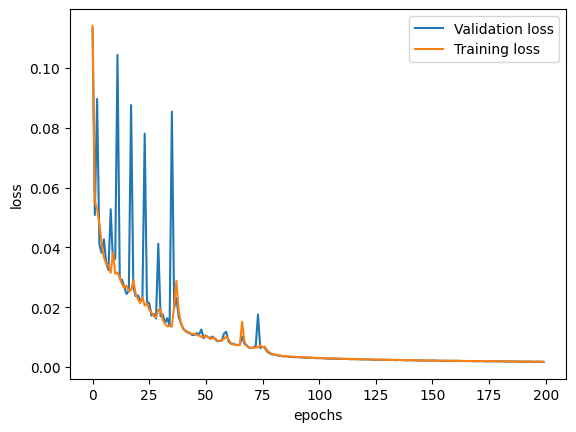

In [16]:
import matplotlib.pyplot as plt
plt.plot(all_val_loss)
plt.plot(all_train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")

In [17]:
import os
import numpy as np
from PIL import Image

# From the best model

# model_weight_path = '/kaggle/input/transunet_till_epoch_150/pytorch/default/1/best_model.pth'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# model = VisionTransformer(config).to(device)

# model.load_state_dict(torch.load(model_weight_path))
# print(model.load_state_dict(torch.load(model_weight_path)))

model.eval()


# Create an output directory for predicted masks
output_dir_work = "/kaggle/working/predicted_masks"
os.makedirs(output_dir_work, exist_ok=True)

output_dir = "/kaggle/outputs/predicted_images/"
os.makedirs(output_dir, exist_ok=True)

# Mapping dictionary
value_mapping = {0: 0, 1: 127, 2: 255}

with torch.no_grad():
    test_loss = []
    test_msk = []
    test_pred_msk = []
    test_img = []
    all_image_names = []
    all_mask_names = []
      
    for batch in test_dataloader:
        test_images, test_masks, img_names, mask_names = batch
        
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        predicted_masks = model(test_images)
        predicted_masks = torch.argmax(predicted_masks, dim=1)

        # predicted_masks = model(test_images)
        # predicted_masks = torch.argmax(predicted_masks, dim=1).cpu().numpy().astype(np.uint8)

        test_img.extend(test_images.cpu().numpy())
        test_msk.extend(test_masks.cpu().numpy())
        test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

        all_image_names.extend(img_names)
        all_mask_names.extend(mask_names)

        # Save predicted masks as PNG images while keeping the original segmentation values (0,1,2)
        for i in range(predicted_masks.shape[0]):
            pred_mask = predicted_masks[i].cpu().numpy()  # Keep class values unchanged (0,1,2)
            # Apply the mapping: 0 → 0, 1 → 127, 2 → 255
            pred_mask = np.vectorize(value_mapping.get)(pred_mask).astype(np.uint8)
            # print(mask_names[i])
            pred_mask_img = Image.fromarray(pred_mask)  # No scaling, original values retained
            pred_mask_path = os.path.join(output_dir_work, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)
            pred_mask_path = os.path.join(output_dir, f"pred_{mask_names[i]}")
            pred_mask_img.save(pred_mask_path)

print(f"Saved predicted masks in: {output_dir}")


    
    # batch = next(iter(test_dataloader))
    # test_images, test_masks, img_names, mask_names = batch
        
    # test_images = test_images.to(device)
    # test_masks = test_masks.to(device)

    # predicted_masks = model(test_images)
    # predicted_masks = torch.argmax(predicted_masks, dim=1)

    # test_img.extend(test_images.cpu().numpy())
    # test_msk.extend(test_masks.cpu().numpy())
    # test_pred_msk.extend(predicted_masks.detach().cpu().numpy())

    # all_image_names.extend(img_names)
    # all_mask_names.extend(mask_names)
  
    
test_dice = dice_coef(test_pred_msk,test_msk)
test_dice_wo = dice_coef_without_class(test_pred_msk,test_msk)
test_iou = iou(test_pred_msk,test_msk)
test_voe = voe(test_pred_msk,test_msk)
test_rvd = rvd(test_pred_msk,test_msk)
      
# Print the loss for the current epoch
print(len(all_mask_names))
print(f"test dice: {test_dice:.4f}, test dice wo: {test_dice_wo}, test jaccard: {test_iou}, test voe: {test_voe}, test rvd: {test_rvd}")

Saved predicted masks in: /kaggle/outputs/predicted_images/
1414
test dice: 0.9589, test dice wo: 1.88771, test jaccard: 16.81026, test voe: 0.05609, test rvd: -0.0151


In [18]:
# till epoch 50
# test dice: 0.9582, test dice wo: 1.88137, test jaccard: 15.8595, test voe: 0.06281, test rvd: -0.0246

# till epoch 100
# test dice: 0.9622, test dice wo: 1.88938, test jaccard: 17.08071, test voe: 0.05436, test rvd: -0.01541

# till epoch 150
# test dice: 0.9600, test dice wo: 1.88824, test jaccard: 16.89573, test voe: 0.05553, test rvd: -0.01553

In [19]:
def relative_volume_difference(y_pred, y_true):
    rvd_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the volumes (i.e., the sum of non-zero pixels)
        V_pred = torch.sum(y_pred_class)
        V_gt = torch.sum(y_true_class)
        
        # Calculate RVD for this class
        if V_gt != 0:
            rvd = torch.abs(V_pred - V_gt) / V_gt
        else:
            rvd = 0  # If the ground truth volume is zero, set RVD to zero (or some other default)
        
        rvd_list.append(rvd)
    
    # Return the mean RVD across all classes
    return torch.mean(torch.tensor(rvd_list))

# Volume Overlap Error (VOE) for multiclass segmentation
def volume_overlap_error(y_pred, y_true):
    voe_list = []
    n_classes = 3
    for class_id in range(n_classes):
        
        y_pred_class = (y_pred == class_id).float()
        y_true_class = (y_true == class_id).float()
        
        # Calculate the intersection and union
        intersection = torch.sum(y_pred_class * y_true_class)
        union = torch.sum(torch.max(y_pred_class, y_true_class))
        
        # Calculate VOE for this class
        if union != 0:
            voe = (union - intersection) / union
        else:
            voe = 0  # If the union is zero, set VOE to zero (or some other default)
        
        voe_list.append(voe)
    
    # Return the mean VOE across all classes
    return torch.mean(torch.tensor(voe_list))

In [20]:
import torch
from torchmetrics import JaccardIndex, Dice

n_classes = 3

# IoU (Jaccard Index) metric
iou_metric = JaccardIndex(task="multiclass", num_classes=n_classes)

# Dice Score metric (also called F1 Score for segmentation)
dice_metric = Dice(num_classes=n_classes, average='macro')

# Convert ground truth and prediction to PyTorch tensors
y_test_tensor = torch.tensor(test_msk, dtype=torch.int64)   # (16, 224, 224)
y_pred_tensor = torch.tensor(test_pred_msk, dtype=torch.int64)   # (16, 224, 224)

# Ensure tensors are on the same device (important for GPUs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y_test_tensor = y_test_tensor.to(device)
y_pred_tensor = y_pred_tensor.to(device)

iou_metric = iou_metric.to(device)
dice_metric = dice_metric.to(device)

# Compute IoU
mean_iou = iou_metric(y_pred_tensor, y_test_tensor)
print("Mean IoU =", mean_iou.item())

# Compute Dice Score
dice_score = dice_metric(y_pred_tensor, y_test_tensor)
print("Dice Score =", dice_score.item())

rvd = relative_volume_difference(y_pred_tensor, y_test_tensor)
print("Relative Volume Difference (RVD) =", rvd.item())

voe = volume_overlap_error(y_pred_tensor, y_test_tensor)
print("Volume Overlap Error (VOE) =", voe.item())


Mean IoU = 0.9324860572814941
Dice Score = 0.9642188549041748
Relative Volume Difference (RVD) = 0.019025620073080063
Volume Overlap Error (VOE) = 0.06751390546560287


In [21]:
# till epoch 50
# Mean IoU = 0.9305775761604309
# Dice Score = 0.9632631540298462
# Relative Volume Difference (RVD) = 0.011938422918319702
# Volume Overlap Error (VOE) = 0.0694224089384079

# till epoch 100
# Mean IoU = 0.9374173283576965
# Dice Score = 0.9670287370681763
# Relative Volume Difference (RVD) = 0.015110134147107601
# Volume Overlap Error (VOE) = 0.06258270144462585

# till epoch 150
# Mean IoU = 0.9341979026794434
# Dice Score = 0.9651991724967957
# Relative Volume Difference (RVD) = 0.017768455669283867
# Volume Overlap Error (VOE) = 0.06580209732055664

1414
00019PSFHSAoP4k_019.png
00019_PSFHAoP4k_mask.png
00027PSFHSAoP4k_027.png
00027_PSFHAoP4k_mask.png
00028PSFHSAoP4k_028.png
00028_PSFHAoP4k_mask.png
00031PSFHSAoP4k_031.png
00031_PSFHAoP4k_mask.png
00038PSFHSAoP4k_038.png
00038_PSFHAoP4k_mask.png


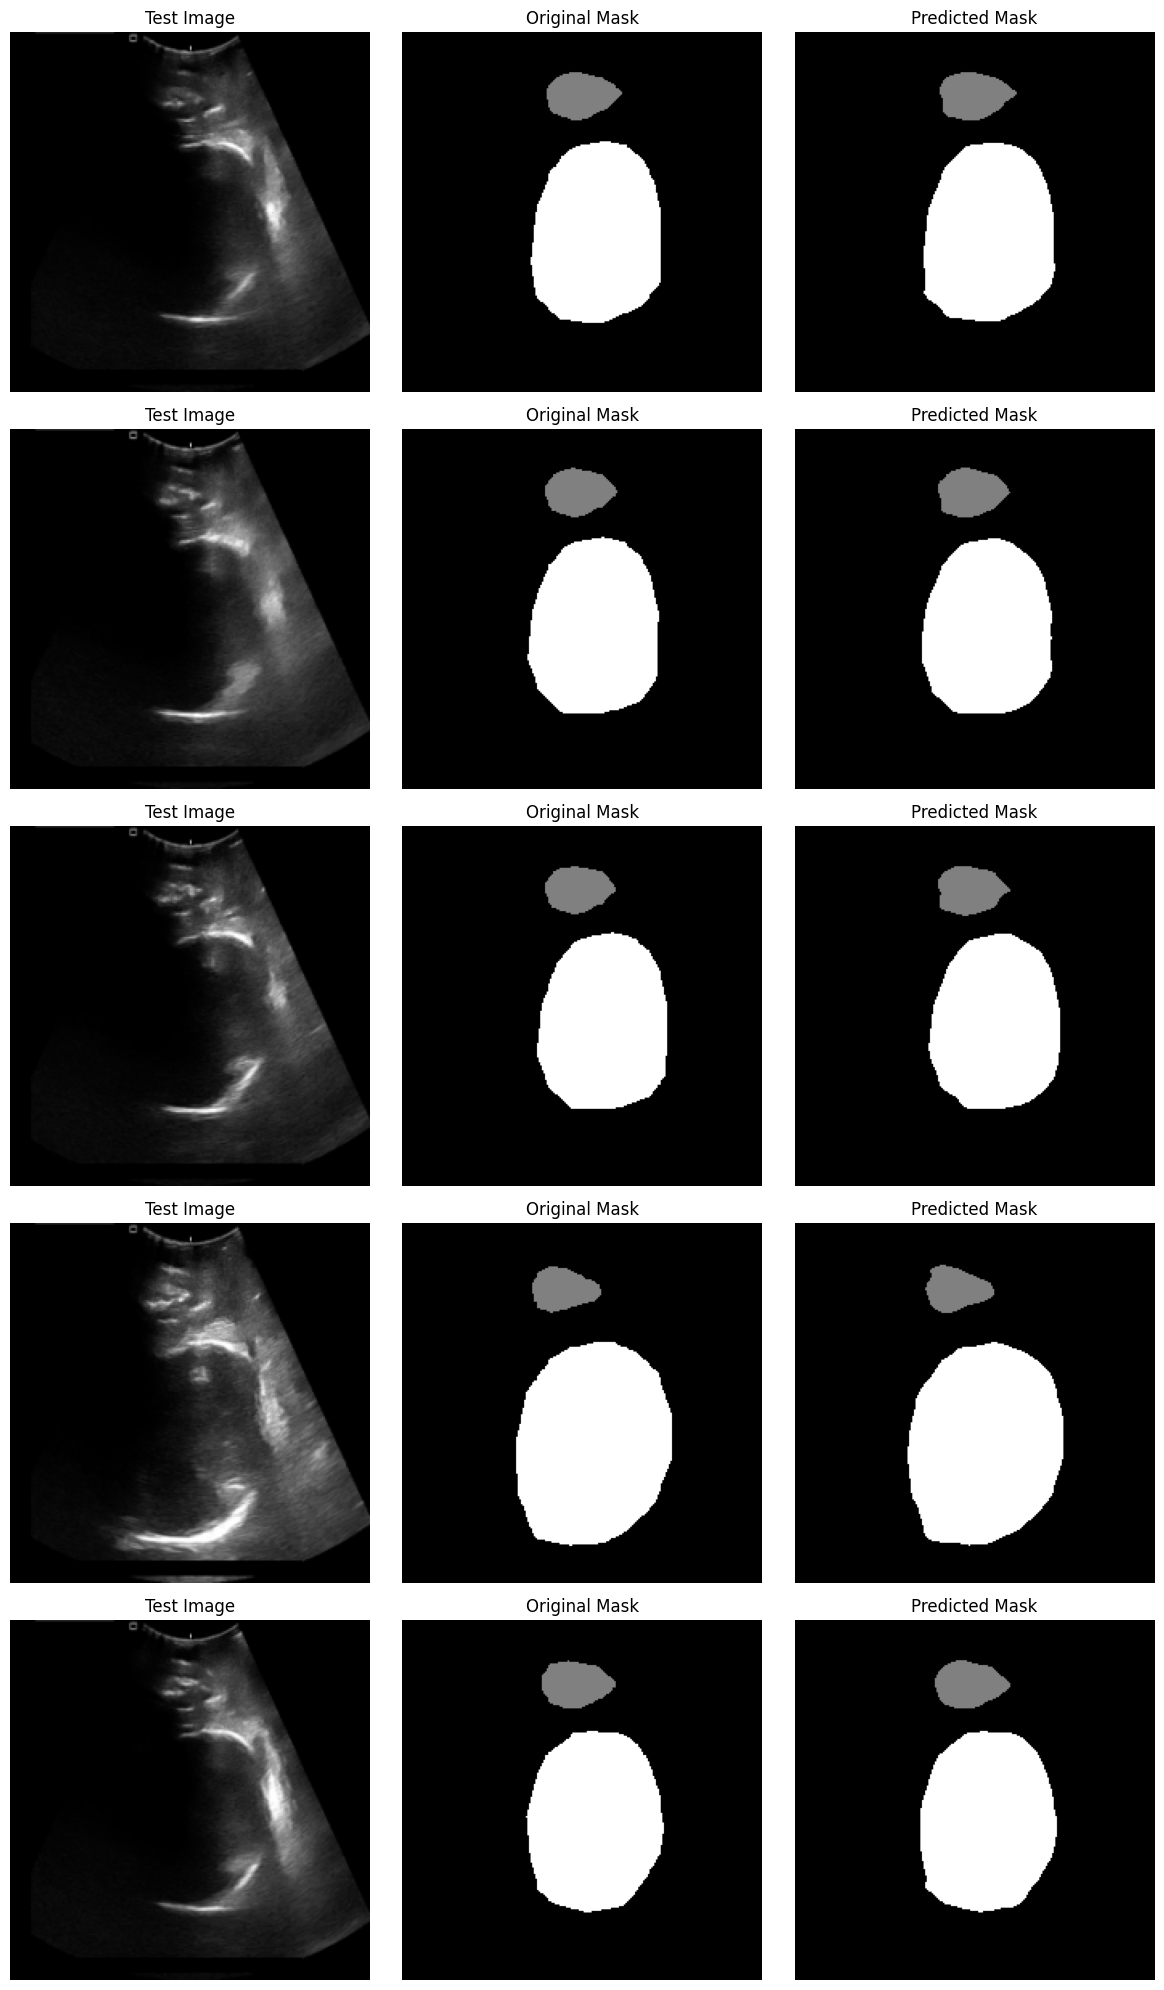

In [22]:
import cv2

test_img = np.array(test_img)
test_msk = np.array(test_msk)
test_pred_msk = np.array(test_pred_msk)

num_images = min(5, test_img.shape[0])  # Show up to 5 images
print(test_img.shape[0])

# Plot original image, ground truth mask, and predicted mask side by side
fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(12, num_images * 4))

for i in range(num_images):
    print(all_image_names[i])
    print(all_mask_names[i])
    # Original Image
    axs[i, 0].imshow(test_img[i, 0], cmap='gray')  # Assuming grayscale images
    axs[i, 0].set_title("Test Image")
    axs[i, 0].axis("off")

    # Ground Truth Mask
    axs[i, 1].imshow(test_msk[i], cmap='gray')  # Ground truth masks with class labels
    axs[i, 1].set_title("Original Mask")
    axs[i, 1].axis("off")

    # Model-Predicted Mask
    axs[i, 2].imshow(test_pred_msk[i], cmap='gray')  # Predicted masks with class labels
    axs[i, 2].set_title("Predicted Mask")
    axs[i, 2].axis("off")

plt.tight_layout()
plt.show()